# Loan Default Predection

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

## Load and Explore the Data

In [86]:
file_path = 'data/Loan_default.csv'
df = pd.read_csv(file_path)
df.head()

,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

There are `255347` rows and `18` columns in our dataset.

There are `10` numerical features and `8` categorical features.

There is no missing value in the dataset.

Our target is `Default` column. `1` is for loan defaulted and `0` is for non-loan defaulted.

In [88]:
print(df['Default'].value_counts())
print(df['Default'].value_counts(normalize=True) * 100)

Default
0    225694
1     29653
Name: count, dtype: int64
Default
0    88.387175
1    11.612825
Name: proportion, dtype: float64


We can see that the dateset is imbalanced.

## Exploratory Data Analysis

### Handling Categorical Features

In [89]:
cat_features = df.select_dtypes(include='object').columns
for col in cat_features:
    print(f"{col}: {df[col].nunique()} unique values")

LoanID: 255347 unique values
Education: 4 unique values
EmploymentType: 4 unique values
MaritalStatus: 3 unique values
HasMortgage: 2 unique values
HasDependents: 2 unique values
LoanPurpose: 5 unique values
HasCoSigner: 2 unique values


We can see, encoding all the categorical features is easy except LoanID.

In [90]:
for col in cat_features:
    print(f"\nFeature: {col}")
    print(df[col].value_counts(normalize=True) * 100)  # Shows percentage distribution
    print("-" * 40)


Feature: LoanID
LoanID
ZTH91CGL0B    0.000392
I38PQUQS96    0.000392
HPSK72WA7R    0.000392
C1OZ6DPJ8Y    0.000392
V2KKSFM3UN    0.000392
                ...   
1MUSHWD9TW    0.000392
LXK7UEMLK0    0.000392
995RE1TIB4    0.000392
D17PDP8LBL    0.000392
C35RYEXWJ0    0.000392
Name: proportion, Length: 255347, dtype: float64
----------------------------------------

Feature: Education
Education
Bachelor's     25.207267
High School    25.025945
Master's       24.884177
PhD            24.882611
Name: proportion, dtype: float64
----------------------------------------

Feature: EmploymentType
EmploymentType
Part-time        25.126984
Unemployed       24.995007
Self-employed    24.948795
Full-time        24.929214
Name: proportion, dtype: float64
----------------------------------------

Feature: MaritalStatus
MaritalStatus
Married     33.406306
Divorced    33.300959
Single      33.292735
Name: proportion, dtype: float64
----------------------------------------

Feature: HasMortgage
HasMort

All the categorical features appear equally(Balanced).

`LoandID` is unque for each value and doesnt do anything for our predection so we can drop it.

The rest apear equally so we can apply One-Hot Encoding.

In [91]:
# Drop LoanID
df = df.drop(columns=['LoanID'])

In [92]:
# Apply One-Hot Encoding
cat_features = df.select_dtypes(include='object').columns

df = pd.get_dummies(df, columns=cat_features, drop_first=True, dtype=int)

In [93]:
df

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default,...,EmploymentType_Unemployed,MaritalStatus_Married,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes
0,56,85994,50587,520,80,4,15.23,36,0.44,0,...,0,0,0,1,1,0,0,0,1,1
1,69,50432,124440,458,15,1,4.81,60,0.68,0,...,0,1,0,0,0,0,0,0,1,1
2,46,84208,129188,451,26,3,21.17,24,0.31,1,...,1,0,0,1,1,0,0,0,0,0
3,32,31713,44799,743,0,3,7.07,24,0.23,0,...,0,1,0,0,0,1,0,0,0,0
4,60,20437,9139,633,8,4,6.51,48,0.73,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255342,19,37979,210682,541,109,4,14.11,12,0.85,0,...,0,1,0,0,0,0,0,0,1,0
255343,32,51953,189899,511,14,2,11.55,24,0.21,1,...,0,0,0,0,0,0,0,1,0,0
255344,56,84820,208294,597,70,3,5.29,60,0.50,0,...,0,1,0,1,1,0,0,0,0,1
255345,42,85109,60575,809,40,1,20.90,48,0.44,0,...,0,0,1,1,1,0,0,0,1,0


### Handling Numerical Features

In [46]:
num_features = df.select_dtypes(include=['int64', 'float64']).columns
df[num_features].describe()

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Default
count,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000,255347.000000
mean,43.498306,82499.304597,127578.865512,574.264346,59.541976,2.501036,13.492773,36.025894,0.500212,0.116128
std,14.990258,38963.013729,70840.706142,158.903867,34.643376,1.117018,6.636443,16.969330,0.230917,0.320379
min,18.000000,15000.000000,5000.000000,300.000000,0.000000,1.000000,2.000000,12.000000,0.100000,0.000000
25%,31.000000,48825.500000,66156.000000,437.000000,30.000000,2.000000,7.770000,24.000000,0.300000,0.000000
50%,43.000000,82466.000000,127556.000000,574.000000,60.000000,2.000000,13.460000,36.000000,0.500000,0.000000
75%,56.000000,116219.000000,188985.000000,712.000000,90.000000,3.000000,19.250000,48.000000,0.700000,0.000000
max,69.000000,149999.000000,249999.000000,849.000000,119.000000,4.000000,25.000000,60.000000,0.900000,1.000000


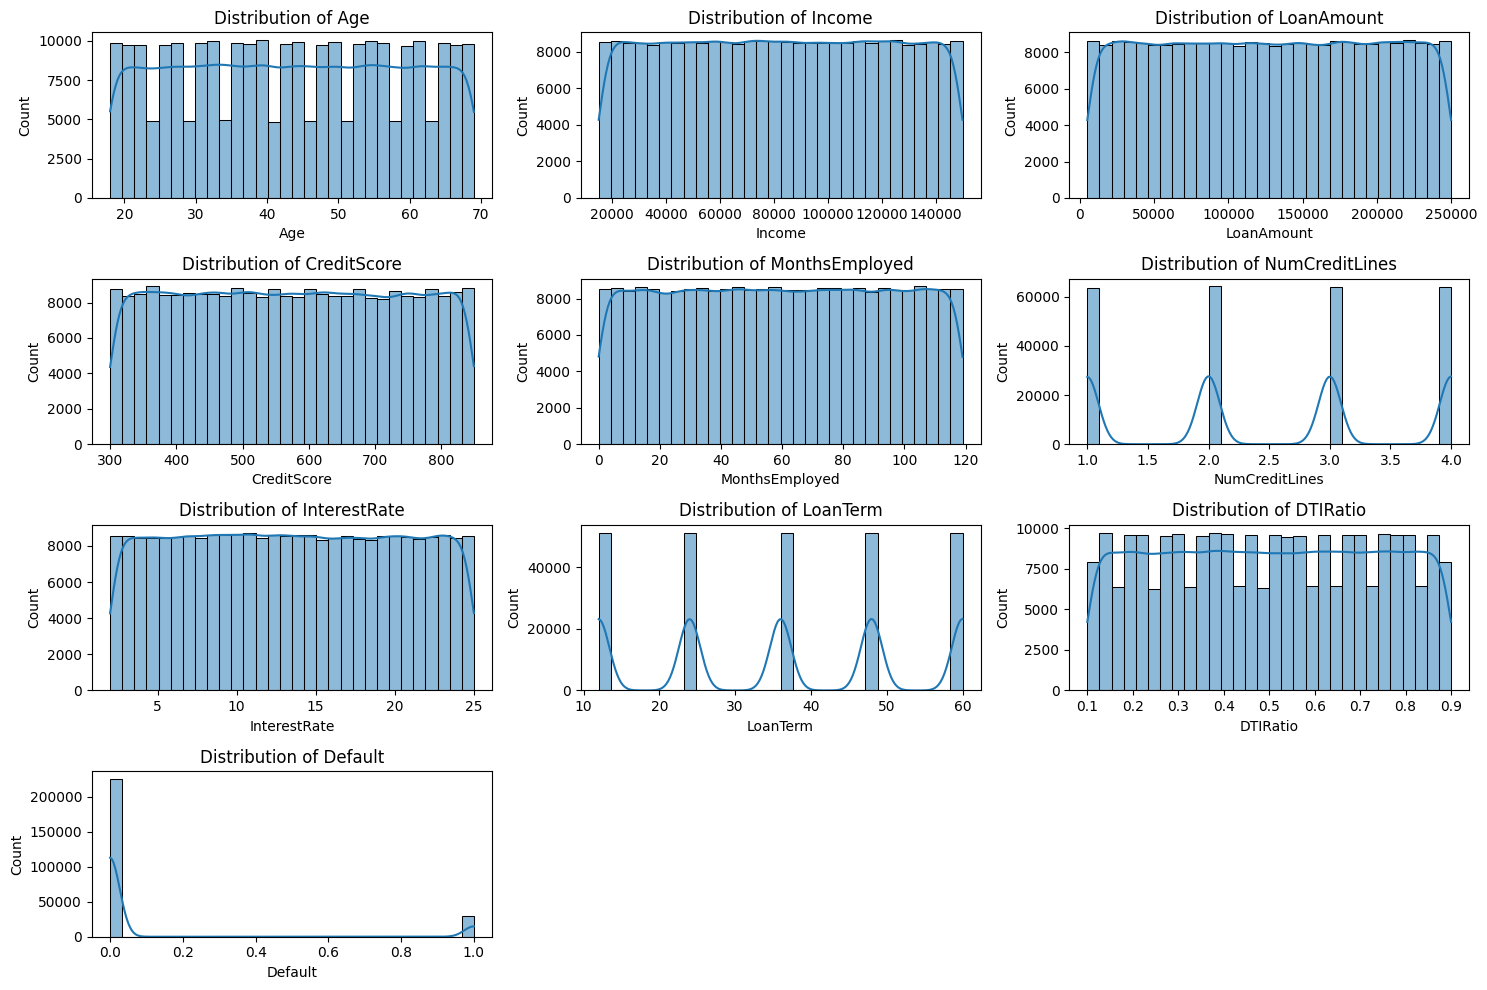

In [77]:
# Plot distributions
plt.figure(figsize=(15,10))
for i, col in enumerate(num_features, 1):
    plt.subplot(4, 3, i)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

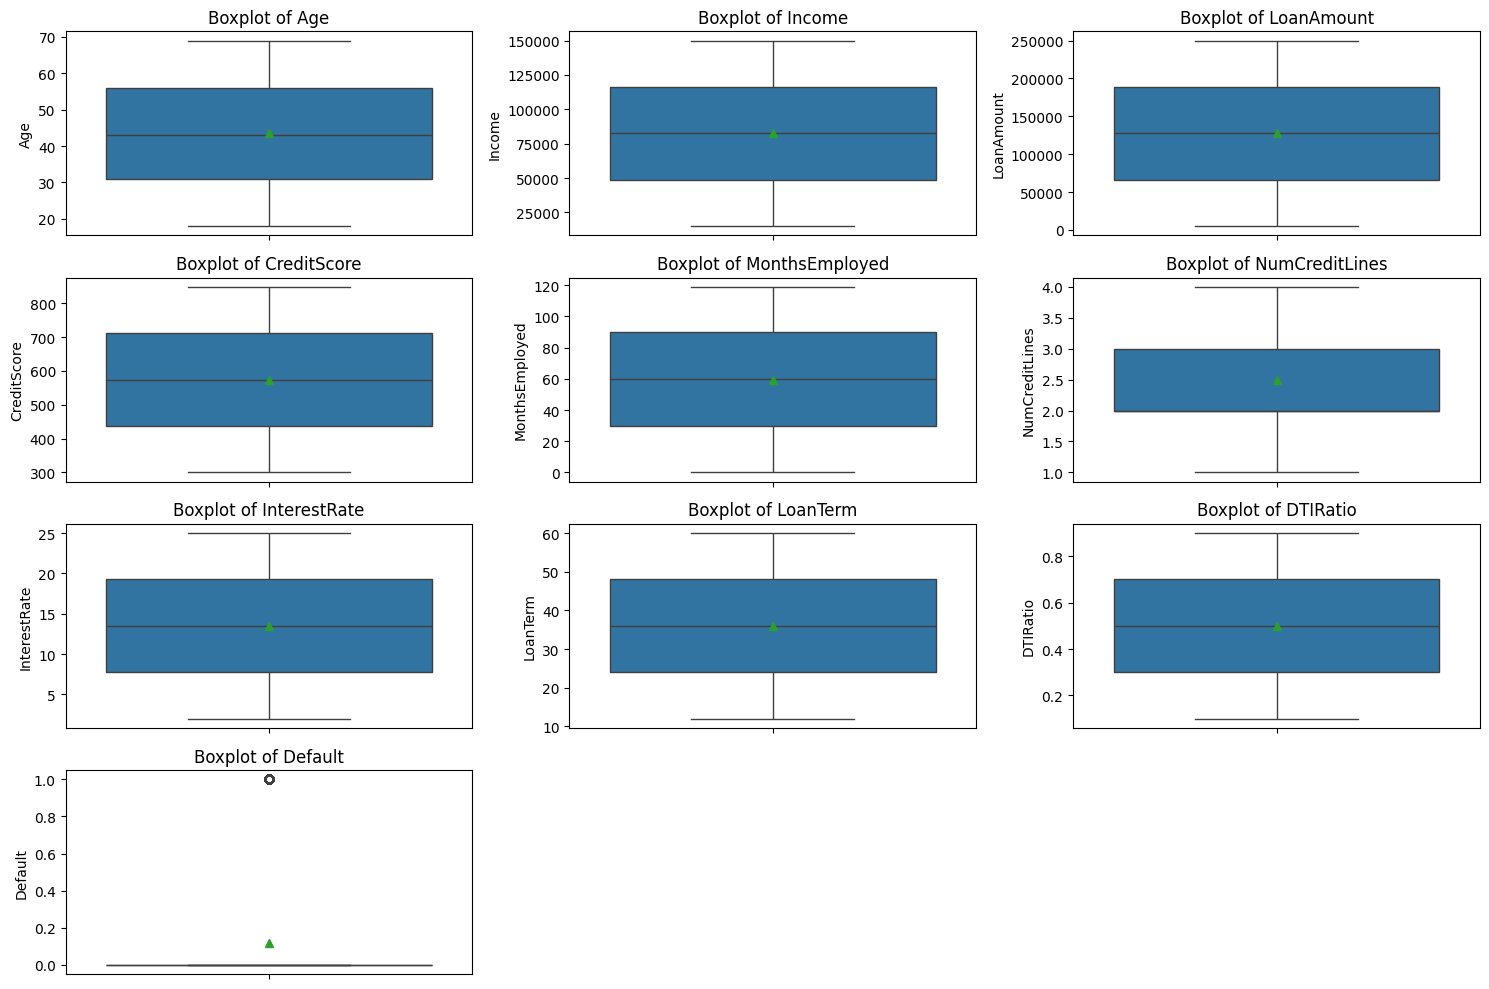

In [79]:
# Plot boxplots to check for outliers
plt.figure(figsize=(15,10))
for i, col in enumerate(num_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=df[col], showmeans=True)
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

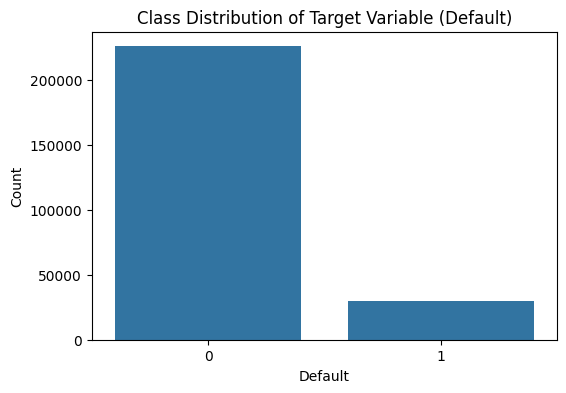

In [80]:
# Plot class distribution
plt.figure(figsize=(6,4))
sns.countplot(x=df['Default'])
plt.title("Class Distribution of Target Variable (Default)")
plt.xlabel("Default")
plt.ylabel("Count")
plt.show()

### Handling Imbalance Target

In [97]:
# Define SMOTE
smote = SMOTE(random_state=42, sampling_strategy=1)

# Separate features and target
X = df.drop(columns=['Default'])
y = df['Default']

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check new class balance
print("Before SMOTE:", Counter(y))
print("After SMOTE:", Counter(y_resampled))

c:\Users\user\OneDrive\Desktop\Loan_Default_Predection\lfp\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\user\OneDrive\Desktop\Loan_Default_Predection\lfp\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\user\OneDrive\Desktop\Loan_Default_Predection\lfp\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\user\AppData\Local\Progra

Before SMOTE: Counter({0: 225694, 1: 29653})
After SMOTE: Counter({0: 225694, 1: 225694})


## Feature Scailing and Model Training

In [103]:
# Define the scaler
scaler = MinMaxScaler()

# Select features to scale
scale_col = num_features.drop(['Default'])

# Apply scaling
X_resampled[scale_col] = scaler.fit_transform(X_resampled[scale_col])

# Check the transformation
print(X_resampled.describe())

                 Age         Income     LoanAmount    CreditScore  \
count  451388.000000  451388.000000  451388.000000  451388.000000   
mean        0.436530       0.465720       0.530296       0.487027   
std         0.274968       0.297191       0.288657       0.268220   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.196078       0.198246       0.284948       0.264117   
50%         0.411765       0.453418       0.545365       0.480874   
75%         0.647059       0.724139       0.785032       0.704918   
max         1.000000       1.000000       1.000000       1.000000   

       MonthsEmployed  NumCreditLines   InterestRate       LoanTerm  \
count   451388.000000   451388.000000  451388.000000  451388.000000   
mean         0.464758        0.459270       0.545075       0.497609   
std          0.270372        0.348190       0.267545       0.327188   
min          0.000000        0.000000       0.000000       0.000000   
25%          0.235294  

### Apply Logistic Regression

In [106]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Initialize and train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8733024657170074

Confusion Matrix:
 [[39912  5227]
 [ 6211 38928]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.88      0.87     45139
           1       0.88      0.86      0.87     45139

    accuracy                           0.87     90278
   macro avg       0.87      0.87      0.87     90278
weighted avg       0.87      0.87      0.87     90278



Precision: `88%` for `Default (1)` means `12% `of predicted defaults were wrong.

 Recall: `86%` for Default (1)` means `14%` of actual defaults were missed.

 F1-score is balanced at `87%`, which is good.

 But we still missed `6,211` actual defaults—which can be risky in a real-world scenario.

### Apply Random Forest

In [108]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.9080174571877977

Confusion Matrix:
 [[43181  1958]
 [ 6346 38793]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     45139
           1       0.95      0.86      0.90     45139

    accuracy                           0.91     90278
   macro avg       0.91      0.91      0.91     90278
weighted avg       0.91      0.91      0.91     90278



Accuracy improved from `87.3%` → `90.8%` (Better at overall predictions).

Recall for `class 0` (No Default) improved to `96%` (Fewer false positives).

Precision for `class 1` (Default) improved to `95%` (Fewer incorrect default predictions).

Recall for `class 1` (Defaults) stayed at `86%` → Still missing some actual defaults.

In [110]:
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  
    'max_depth': [10, 20, None],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize Random Forest model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# Perform Grid Search
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='f1', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Train the optimized model
best_rf = grid_search.best_estimator_
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate performance
print("Optimized Random Forest Accuracy:", accuracy_score(y_test, y_pred_best_rf))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_rf))

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Optimized Random Forest Accuracy: 0.909025454706573

Confusion Matrix:
 [[43234  1905]
 [ 6308 38831]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91     45139
           1       0.95      0.86      0.90     45139

    accuracy                           0.91     90278
   macro avg       0.91      0.91      0.91     90278
weighted avg       0.91      0.91      0.91     90278



1. Model is Slightly More Accurate `(90.9%)`

Optimization helped fine-tune the splits, but the improvement is small.

2. False Positives & False Negatives Reduced Slightly

The model is slightly better at identifying defaults correctly.
But recall (catching defaulters) remains at `86%`.

3. No Significant Gain Over Baseline Random Forest
Since the performance didn’t drastically improve, we should now test XGBoost to see if it can outperform Random Forest.

In [112]:
# Initialize XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=1.5)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.9094463767473803

Confusion Matrix:
 [[41930  3209]
 [ 4966 40173]]

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.93      0.91     45139
           1       0.93      0.89      0.91     45139

    accuracy                           0.91     90278
   macro avg       0.91      0.91      0.91     90278
weighted avg       0.91      0.91      0.91     90278



1. XGBoost Has Higher Recall `(89%)`
XGBoost correctly catches more actual defaulters `(1s)` than Random Forest.
This is important for banks/lenders because missing defaults (false negatives) is costly.

2. XGBoost Increases False Positives
`3,209` non-defaulters `(0s)` were mistakenly predicted as defaulters.
This could mean some good customers might be unfairly flagged.

3. XGBoost Slightly Improves Overall Accuracy
Final accuracy is `90.94%`, slightly higher than `90.9%` for Random Forest.
Not a huge difference, but the higher recall is more valuable for this problem.
